Аффинивный анализ данных на основе информации, полученной из google sheets, куда студенты группы вносили ИУ5-54Б свои чеки.


# Аффинитивный анализ чеков покупок

### Data Preprocessing and EDA

In [39]:
%pip install --index-url https://test.pypi.org/simple/ PyARMViz

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


In [40]:

import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from PyARMViz import PyARMViz

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-poster')

TypeError: Parameters to generic types must be types. Got <module 'PyARMViz.Rule' from 'c:\\Users\\shaki\\AppData\\Local\\Programs\\Python\\Python310\\lib\\si.

In [18]:
from openpyxl import load_workbook
import os
directory = 'checks.xlsx'
data = pd.read_excel(directory)
df = pd.DataFrame(data)
df

,ID Транзакции,Дата,Продукт,Кол-во,"Цена, Руб.","Итоговая стоимость, Руб."
0,38495,23.06.2024,Горбуша,9,425,3825
1,38495,23.06.2024,Молочные продукты,9,759,6831
2,38495,23.06.2024,Масло оливковое,5,55,275
3,333722,26.02.2024,Лепешки,2,164,328
4,333722,26.02.2024,Фисташки,7,577,4039
...,...,...,...,...,...,...
600484,234718,21.08.2024,Гречка,8,148,1184
600485,234718,21.08.2024,Буженина,4,71,284
600486,234718,21.08.2024,Фрукты замороженные,10,280,2800
600487,234718,21.08.2024,Лимон,10,320,3200


Нам понадобятся только транзакция, товар и дата-время. Изучим, на примере 10 самых продаваемых продуктов в магазине используя сетевую диаграмму.

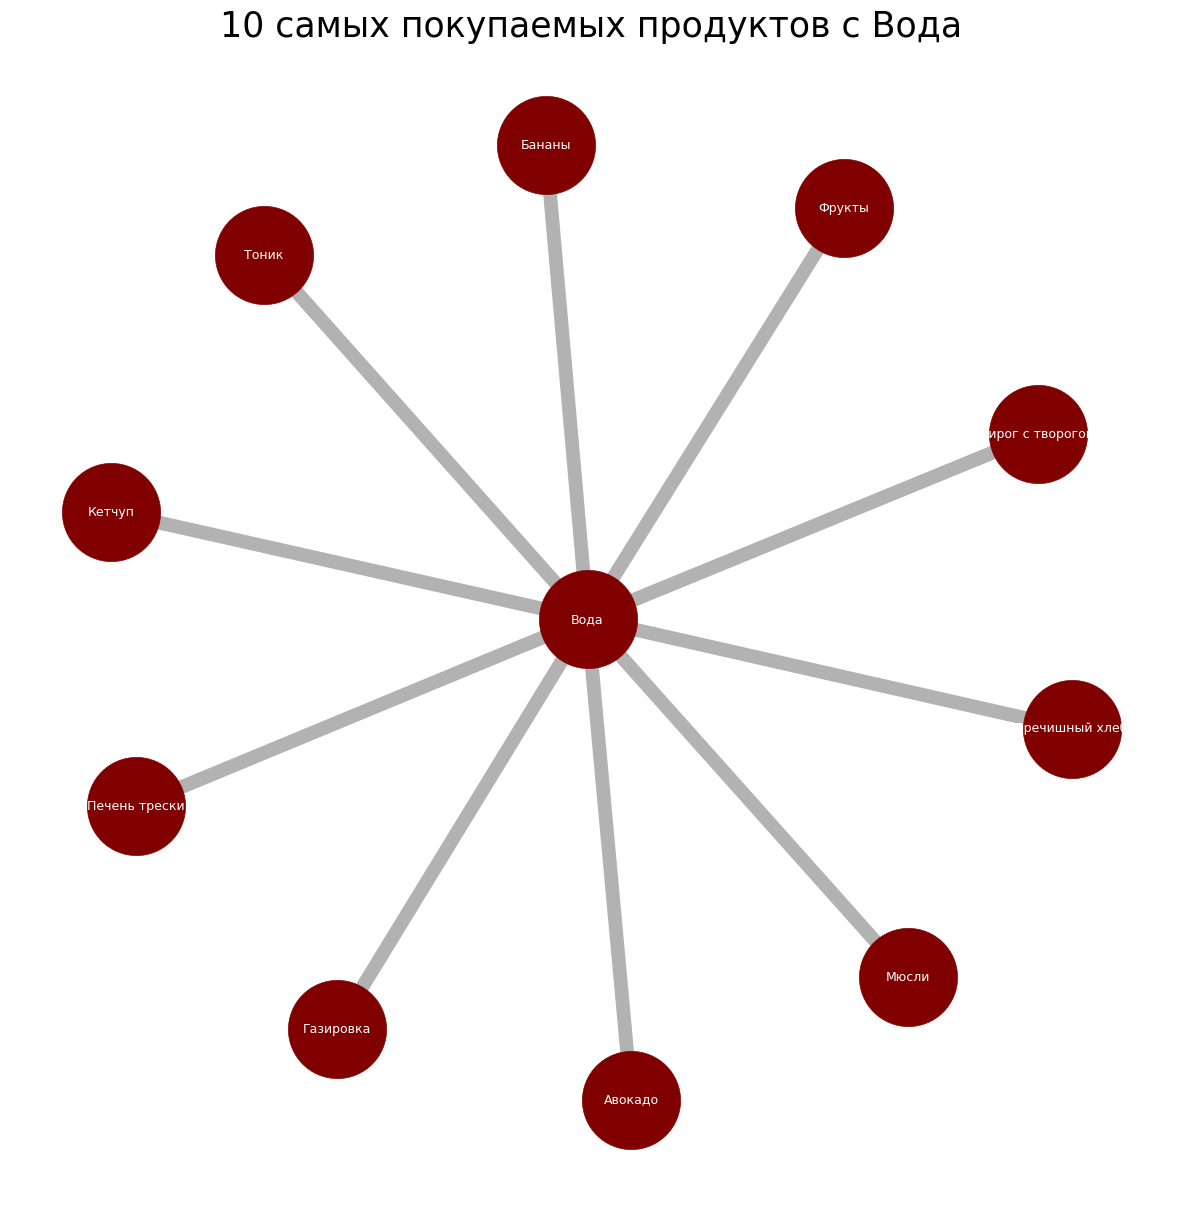

In [20]:
# Стандартизируем формат столбца «Данные».
df["Дата"] = pd.to_datetime(df["Дата"])

# Удаляем дубликаты "ID Транзакции" and "Продукт"
df = df.drop_duplicates(subset=["ID Транзакции", "Продукт"])

# Group by "Продукт" and count transactions
data_vis = df.copy()
df_network_first = (
    data_vis.groupby("Продукт")
    .size()
    .reset_index(name="Transaction")
    .sort_values("Transaction", ascending=False)
)
product = "Вода"
df_network_first["Type"] = product

# Получаем топ 10 продуктов
df_network_first = df_network_first.head(10)

# Создаем графовую сеть
weights = df_network_first["Transaction"].values
df_network_first = df_network_first.drop(df_network_first[df_network_first["Продукт"] == product].index)
first_choice = nx.from_pandas_edgelist(df_network_first, source="Type", target="Продукт")

# весы для визуализации
weights = [10 * w / max(weights) for w in weights]
pos = nx.spring_layout(first_choice)

plt.rcParams["figure.figsize"] = (15, 15)
nx.draw_networkx_nodes(first_choice, pos, node_size=5000, node_color="maroon")
nx.draw_networkx_edges(first_choice, pos, width=weights, alpha=0.3, edge_color="black")
nx.draw_networkx_labels(first_choice, pos, font_size=9, font_family="sans-serif", font_color="white")

plt.axis("off")
plt.grid()
plt.title(f"10 самых покупаемых продуктов с {product}", fontsize=25)
plt.show()

 Этот график показывает связь продукта "Бананы" с другими продуктами, которые покупают вместе с ним. Из результата видно, что продукты, такие как "Сыр", "Газировка", "Алкоголь", "Вода", "Молоко", "Хлеб", "Картофель", "Курица" и "Колбаса", чаще всего встречаются в одних чеках с "Бананами".

Толщина линий на графике указывает на интенсивность связи (чем толще линия, тем чаще эти продукты покупаются вместе). Такой анализ помогает выявить популярные товарные комбинации, которые могут быть использованы для улучшения выкладки товаров в магазинах или создания акций.

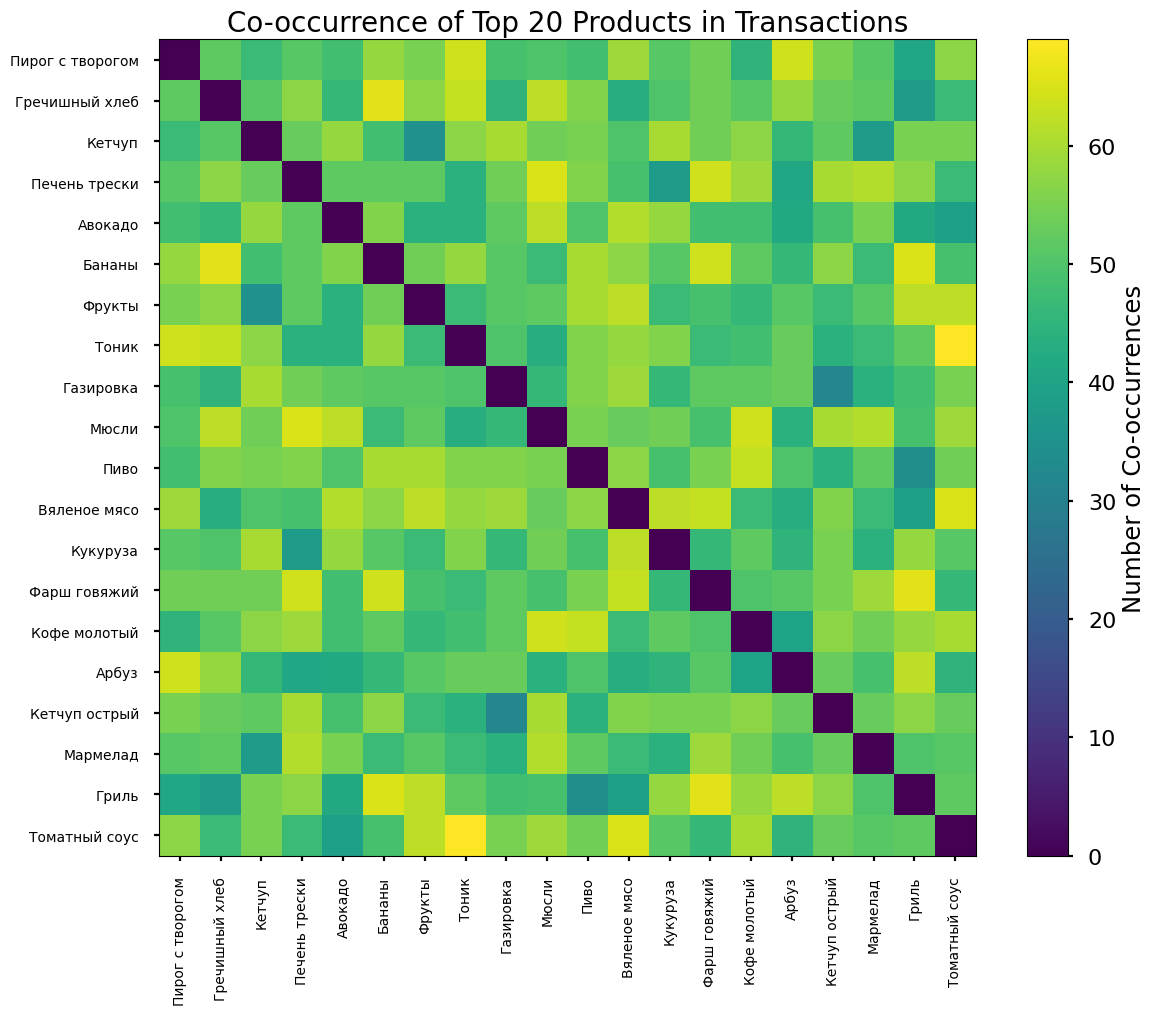

In [21]:
co_occurrence = pd.crosstab(df["ID Транзакции"], df["Продукт"])

# Отфильтруем 20 топ-продуктов по общему совпадению.
top_products = co_occurrence.sum(axis=0).sort_values(ascending=False).head(20).index
co_occurrence_filtered = co_occurrence[top_products]

# Рассчитываем матрицу совпадений для 20 лучших продуктов.
co_occurrence_matrix_filtered = co_occurrence_filtered.T.dot(co_occurrence_filtered)

# Удаляем автокорреляции для отфильтрованной матрицы
for item in co_occurrence_matrix_filtered.columns:
    co_occurrence_matrix_filtered.loc[item, item] = 0

plt.figure(figsize=(12, 10))
plt.title("Co-occurrence of Top 20 Products in Transactions", fontsize=20)
plt.imshow(co_occurrence_matrix_filtered, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Number of Co-occurrences")

plt.xticks(range(len(co_occurrence_matrix_filtered.columns)), co_occurrence_matrix_filtered.columns, rotation=90, fontsize=10)
plt.yticks(range(len(co_occurrence_matrix_filtered.columns)), co_occurrence_matrix_filtered.columns, fontsize=10)

plt.tight_layout()
plt.show()

График показывает частоту совместной покупки 20 самых популярных товаров. Наиболее сильная взаимосвязь наблюдается между базовыми продуктами, такими как "Молоко" и "Хлеб", "Курица" и "Картофель". Это указывает на типичные повседневные покупки. Более слабые связи видны между менее часто совмещаемыми продуктами, такими как "Конфеты" и "Сливки".

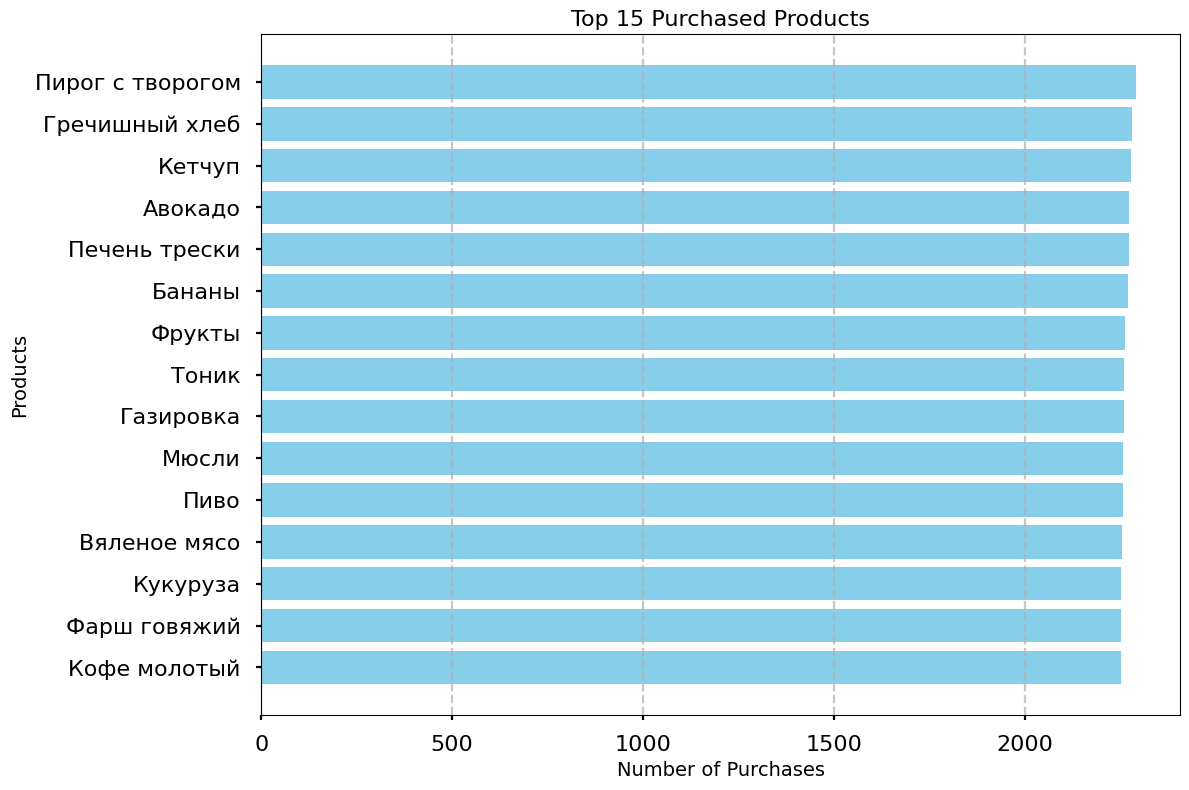

In [22]:

# Подсчитываем количество транзакций для каждого продукта
product_purchase_frequency = df["Продукт"].value_counts().head(15)  # Top 15 products

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.barh(product_purchase_frequency.index, product_purchase_frequency.values, color="skyblue")
plt.xlabel("Number of Purchases", fontsize=14)
plt.ylabel("Products", fontsize=14)
plt.title("Top 15 Purchased Products", fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


На графике видно, что "Молоко" и "Хлеб" являются лидерами по количеству покупок, за ними следуют "Бананы" и "Сыр". Это указывает на то, что данные продукты наиболее востребованы среди покупателей. Остальные продукты, такие как "Алкоголь", "Вода" и "Газировка", занимают средние позиции, что говорит о популярности базовых и повседневных товаров.

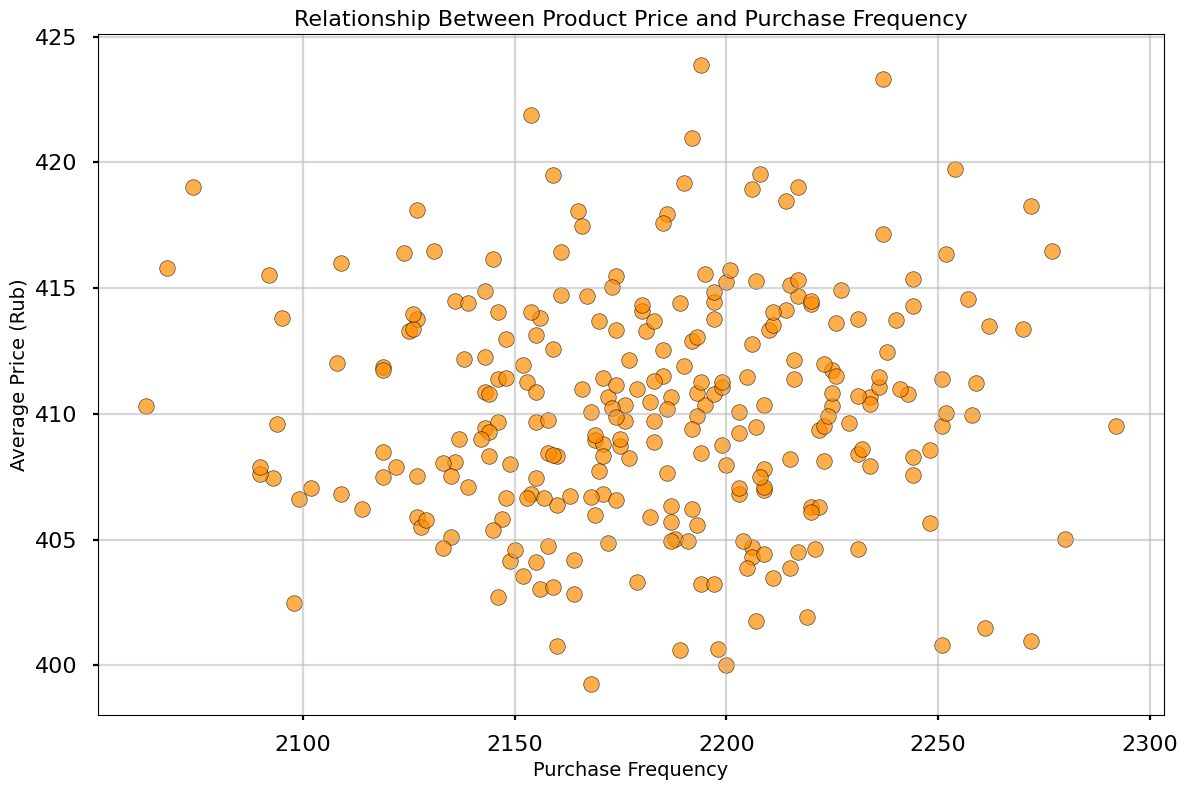

In [23]:
# Создаем диаграммы рассеяния для анализа взаимосвязи между ценой продукта и частотой покупок.

# Рассчитываем среднюю цену на каждый товар
average_price = df.groupby("Продукт")["Цена, Руб."].mean()

# Рассчитываем частоту покупок для каждого продукта
purchase_frequency = df["Продукт"].value_counts()


price_vs_frequency = pd.DataFrame({
    "Average Price (Rub)": average_price,
    "Purchase Frequency": purchase_frequency
}).dropna()

plt.figure(figsize=(12, 8))
plt.scatter(
    price_vs_frequency["Purchase Frequency"],
    price_vs_frequency["Average Price (Rub)"],
    c="darkorange", alpha=0.7, edgecolors="k"
)
plt.xlabel("Purchase Frequency", fontsize=14)
plt.ylabel("Average Price (Rub)", fontsize=14)
plt.title("Relationship Between Product Price and Purchase Frequency", fontsize=16)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

График показывает, что наиболее часто покупаются товары с низкой средней ценой (до 500 рублей), тогда как дорогие продукты (выше 2000 рублей) приобретаются значительно реже. Это подтверждает, что цена сильно влияет на спрос.

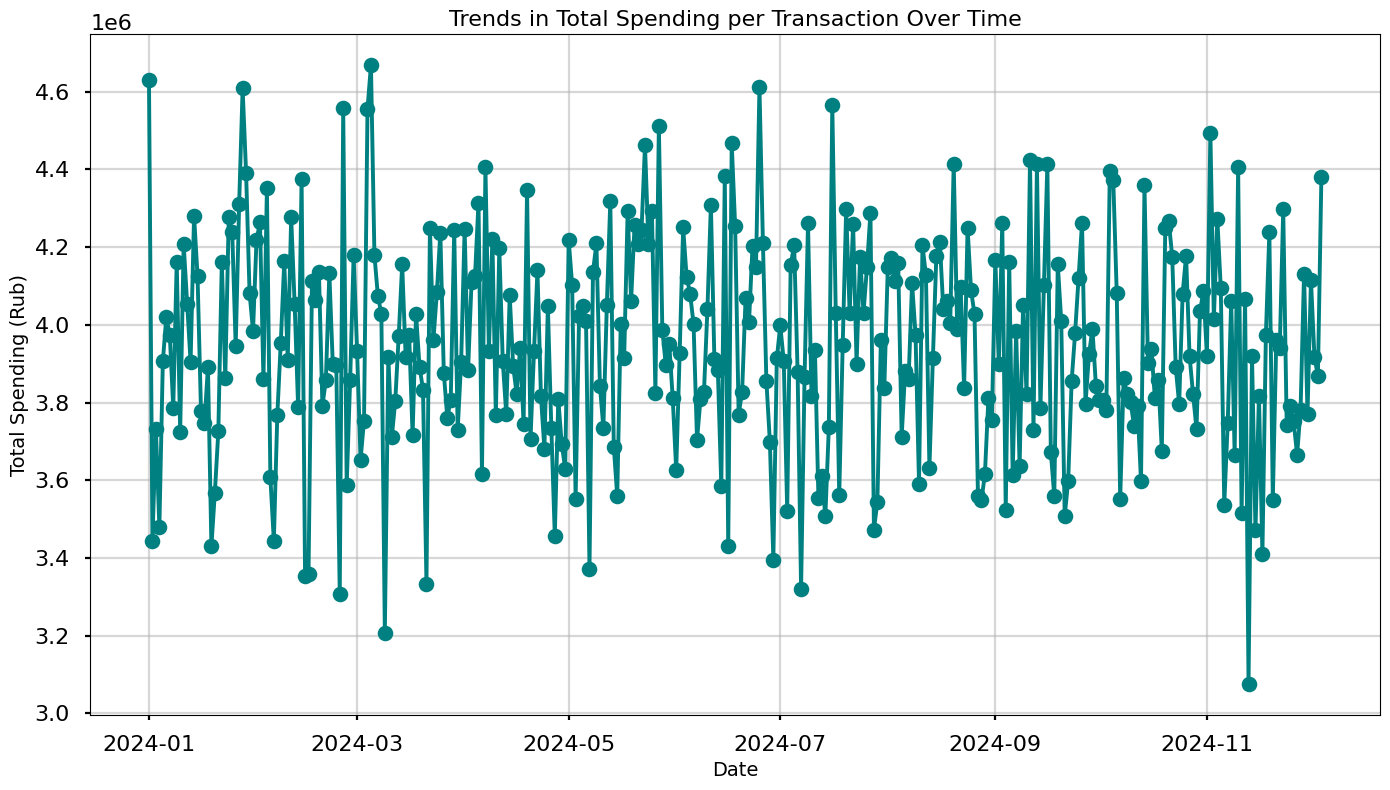

In [24]:
# Создаём линейный график, показывающего тенденции общих расходов на транзакцию с течением времени.

# Группировка данных по дате для расчета общих расходов за день
df['Дата'] = pd.to_datetime(df['Дата'])
daily_spending = df.groupby('Дата')['Итоговая стоимость, Руб.'].sum()

# Plotting the line graph
plt.figure(figsize=(14, 8))
plt.plot(daily_spending.index, daily_spending.values, marker='o', linestyle='-', color='teal')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Spending (Rub)", fontsize=14)
plt.title("Trends in Total Spending per Transaction Over Time", fontsize=16)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


График показывает тенденцию роста общих расходов на покупки в течение времени, с пиками в середине ноября. Это может указывать на сезонные покупки или акционные периоды. Небольшие спады между пиками могут отражать завершение активных периодов покупок.

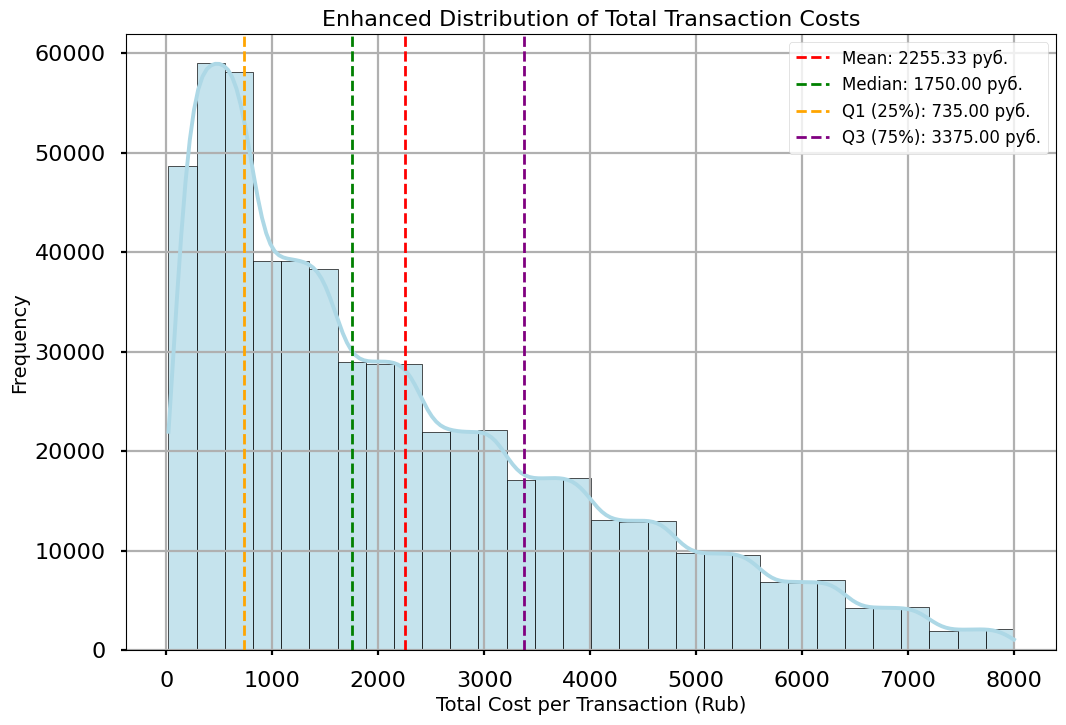

In [25]:
import seaborn as sns

# Наложение дополнительных линий и деталей на гистограмму для улучшения анализа.

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Итоговая стоимость, Руб.', bins=30, kde=True, color="lightblue", alpha=0.7)
plt.axvline(df['Итоговая стоимость, Руб.'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['Итоговая стоимость, Руб.'].mean():.2f} руб.")
plt.axvline(df['Итоговая стоимость, Руб.'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df['Итоговая стоимость, Руб.'].median():.2f} руб.")

q1 = df['Итоговая стоимость, Руб.'].quantile(0.25)
q3 = df['Итоговая стоимость, Руб.'].quantile(0.75)
plt.axvline(q1, color='orange', linestyle='--', linewidth=2, label=f"Q1 (25%): {q1:.2f} руб.")
plt.axvline(q3, color='purple', linestyle='--', linewidth=2, label=f"Q3 (75%): {q3:.2f} руб.")

plt.title("Enhanced Distribution of Total Transaction Costs", fontsize=16)
plt.xlabel("Total Cost per Transaction (Rub)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

График показывает распределение итоговой стоимости чеков. Большинство транзакций сосредоточено в диапазоне до 500 рублей, что указывает на низкую стоимость средних покупок. Среднее значение (315.73 руб.) выше медианы (150 руб.), что свидетельствует о наличии редких, но более крупных затрат, которые смещают среднее. Квартильные значения (Q1: 83.25 руб., Q3: 305.50 руб.) показывают значительное скопление данных в нижней части распределения.

# Моделирование данных

Смоделируем алгоритм Apriori. Сначала сгенерируем набор часто используемых элементов, а затем правила ассоциации, используя набор часто используемых элементов. Нам нужно убедиться, что мы сгенерировали матрицу со значениями 0/1, представляющими наличие транзакции этого элемента.

In [27]:
from mlxtend.frequent_patterns import association_rules, apriori

# Функция для преобразования данных в формат 0/1
def encoder(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# Создание сводной таблицы для Apriori
apriori_data = df.groupby(['ID Транзакции', 'Продукт'])['Кол-во'].sum().reset_index(name='Count')
apriori_basket = apriori_data.pivot_table(index='ID Транзакции', columns='Продукт', values='Count', aggfunc='sum').fillna(0)

# Преобразование данных в бинарный формат (0/1)
apriori_basket_set = apriori_basket.applymap(encoder)

# Проверяем результат
print(apriori_basket_set.head())

Продукт        Авокадо  Алкоголь  Ананас  Арахис  Арбуз  Арбуз дынный  \
ID Транзакции                                                           
4                    0         0       0       0      0             0   
17                   0         0       0       0      0             0   
18                   0         0       0       0      0             0   
22                   0         0       0       0      0             0   
36                   0         0       0       0      0             0   

Продукт        Базилик  Бананы  Безалкогольное пиво  Бекон  ...  Шалфей  \
ID Транзакции                                               ...           
4                    0       0                    0      0  ...       0   
17                   0       0                    0      0  ...       0   
18                   0       0                    0      0  ...       0   
22                   0       0                    0      0  ...       0   
36                   0       0        

In [28]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

In [29]:
apriori_basket_set.head()

Продукт,Авокадо,Алкоголь,Ананас,Арахис,Арбуз,Арбуз дынный,Базилик,Бананы,Безалкогольное пиво,Бекон,...,Шалфей,Шампиньоны,Шарлотка,Шафран,Шашлык,Шоколад,Энергетики,Яблоки,Ягоды,Яйца
ID Транзакции,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
apriori_basket = pd.crosstab(df["ID Транзакции"], df["Продукт"])

# Преобразуем значения в булевый тип
apriori_basket_set = apriori_basket.astype(bool)
apriori_basket_set.head()

Продукт,Авокадо,Алкоголь,Ананас,Арахис,Арбуз,Арбуз дынный,Базилик,Бананы,Безалкогольное пиво,Бекон,...,Шалфей,Шампиньоны,Шарлотка,Шафран,Шашлык,Шоколад,Энергетики,Яблоки,Ягоды,Яйца
ID Транзакции,,,,,,,,,,,,,,,,,,,,,
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Генерация частых наборов при минимальной поддержке 0.05
f_items_05 = apriori(apriori_basket_set, min_support=0.05, use_colnames=True)
f_items_05.info()  # Информация о сгенерированных наборах


# Генерация частых наборов с минимальной поддержкой 0.01
f_items_01 = apriori(apriori_basket_set, min_support=0.01, use_colnames=True, low_memory=True)
f_items_01.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   0 non-null      float64
 1   itemsets  0 non-null      object 
dtypes: float64(1), object(1)
memory usage: 124.0+ bytes


,support,itemsets
0,0.02272,(Авокадо)
1,0.02192,(Алкоголь)
2,0.02185,(Ананас)
3,0.02172,(Арахис)
4,0.02251,(Арбуз)


In [35]:
# Генерация правил ассоциации для частых наборов (минимальная lift = 0.05)
apriori_rules_05 = association_rules(f_items_05, metric='lift', min_threshold=0.05, num_itemsets=len(apriori_basket_set))

# Сортировка правил по уверенности в порядке убывания
apriori_rules_05.sort_values('confidence', ascending=False, inplace=True)

# Просмотр сгенерированных правил
apriori_rules_05

ValueError: The input DataFrame `df` containing the frequent itemsets is empty.

In [32]:
# Генерация частых наборов с минимальной поддержкой 0.01
f_items_01 = apriori(apriori_basket_set, min_support=0.01, use_colnames=True)

# Просмотр частых наборов
f_items_01

,support,itemsets
0,0.104294,(Алкоголь)
1,0.021472,(Апельсины)
2,0.116564,(Бананы)
3,0.030675,(Батончик)
4,0.018405,(Билет)
...,...,...
493,0.012270,"(Молоко, Сыр, Печенье, Хлеб)"
494,0.012270,"(Яйца, Молоко, Сыр, Хлеб)"
495,0.012270,"(Хлеб, Бананы, Яйца, Колбаса, Молоко)"
496,0.012270,"(Сыр, Хлеб, Бананы, Яйца, Колбаса)"


In [33]:
# Список интересующих пар продуктов для анализа
pairs = [
    frozenset({'Молоко', 'Хлеб'}),
    frozenset({'Молоко', 'Яйца'}),
    frozenset({'Молоко', 'Яблоки'}),
    frozenset({'Бананы', 'Молоко'}),
    frozenset({'Молоко', 'Сыр'}),
    frozenset({'Колбаса', 'Молоко'}),
    frozenset({'Колбаса', 'Яйца'}),
    frozenset({'Хлеб', 'Яйца'}),
    frozenset({'Бананы', 'Яйца'}),
    frozenset({'Колбаса', 'Сыр'})
]

# Просмотр уникальных пар
pairs

[frozenset({'Молоко', 'Хлеб'}),
 frozenset({'Молоко', 'Яйца'}),
 frozenset({'Молоко', 'Яблоки'}),
 frozenset({'Бананы', 'Молоко'}),
 frozenset({'Молоко', 'Сыр'}),
 frozenset({'Колбаса', 'Молоко'}),
 frozenset({'Колбаса', 'Яйца'}),
 frozenset({'Хлеб', 'Яйца'}),
 frozenset({'Бананы', 'Яйца'}),
 frozenset({'Колбаса', 'Сыр'})]

In [34]:
# Извлечение уникальных продуктов из частых наборов
unique_list = set()
for item in pairs:
    unique_list.update(item)

# Вывод уникальных продуктов
unique_list

{'Бананы', 'Колбаса', 'Молоко', 'Сыр', 'Хлеб', 'Яблоки', 'Яйца'}

In [35]:
# Создание списка уникальных продуктов из заданных пар
unique_list = []
for pair in pairs:
    unique_list.extend(list(pair))
unique_list = list(set(unique_list))  # Удаление дубликатов

# Получение транзакций для каждого уникального продукта
unique_trans = []
for product in unique_list:
    transactions = set(apriori_data[apriori_data['Продукт'] == product]["ID Транзакции"].tolist())
    unique_trans.append(transactions)

# Сопоставление продуктов с их транзакциями
dict_trans = {unique_list[i]: unique_trans[i] for i in range(len(unique_list))}

# Вычисление пересечений транзакций для каждой пары продуктов
height = []
for pair in pairs:
    products = list(pair)
    intersection = len(dict_trans[products[0]] & dict_trans[products[1]])
    height.append(intersection)

# Вывод результата
print("Список уникальных продуктов:", unique_list)
print("Пересечения транзакций для пар продуктов:", height)

Список уникальных продуктов: ['Сыр', 'Хлеб', 'Бананы', 'Яйца', 'Колбаса', 'Молоко', 'Яблоки']
Пересечения транзакций для пар продуктов: [23, 15, 13, 16, 15, 11, 9, 9, 8, 12]


In [36]:
# Преобразование каждой пары в строку
pairs = [str(list(pair)) for pair in pairs]

# Проверим результат
print(pairs)

["['Молоко', 'Хлеб']", "['Яйца', 'Молоко']", "['Молоко', 'Яблоки']", "['Молоко', 'Бананы']", "['Молоко', 'Сыр']", "['Молоко', 'Колбаса']", "['Яйца', 'Колбаса']", "['Яйца', 'Хлеб']", "['Яйца', 'Бананы']", "['Сыр', 'Колбаса']"]


In [37]:
# Создание DataFrame для отображения пар и количества транзакций
df_plot = pd.DataFrame({
    "Пары продуктов": pairs,
    "Количество транзакций": height
})

# Проверка результата
print(df_plot.head())


         Пары продуктов  Количество транзакций
0    ['Молоко', 'Хлеб']                     23
1    ['Яйца', 'Молоко']                     15
2  ['Молоко', 'Яблоки']                     13
3  ['Молоко', 'Бананы']                     16
4     ['Молоко', 'Сыр']                     15


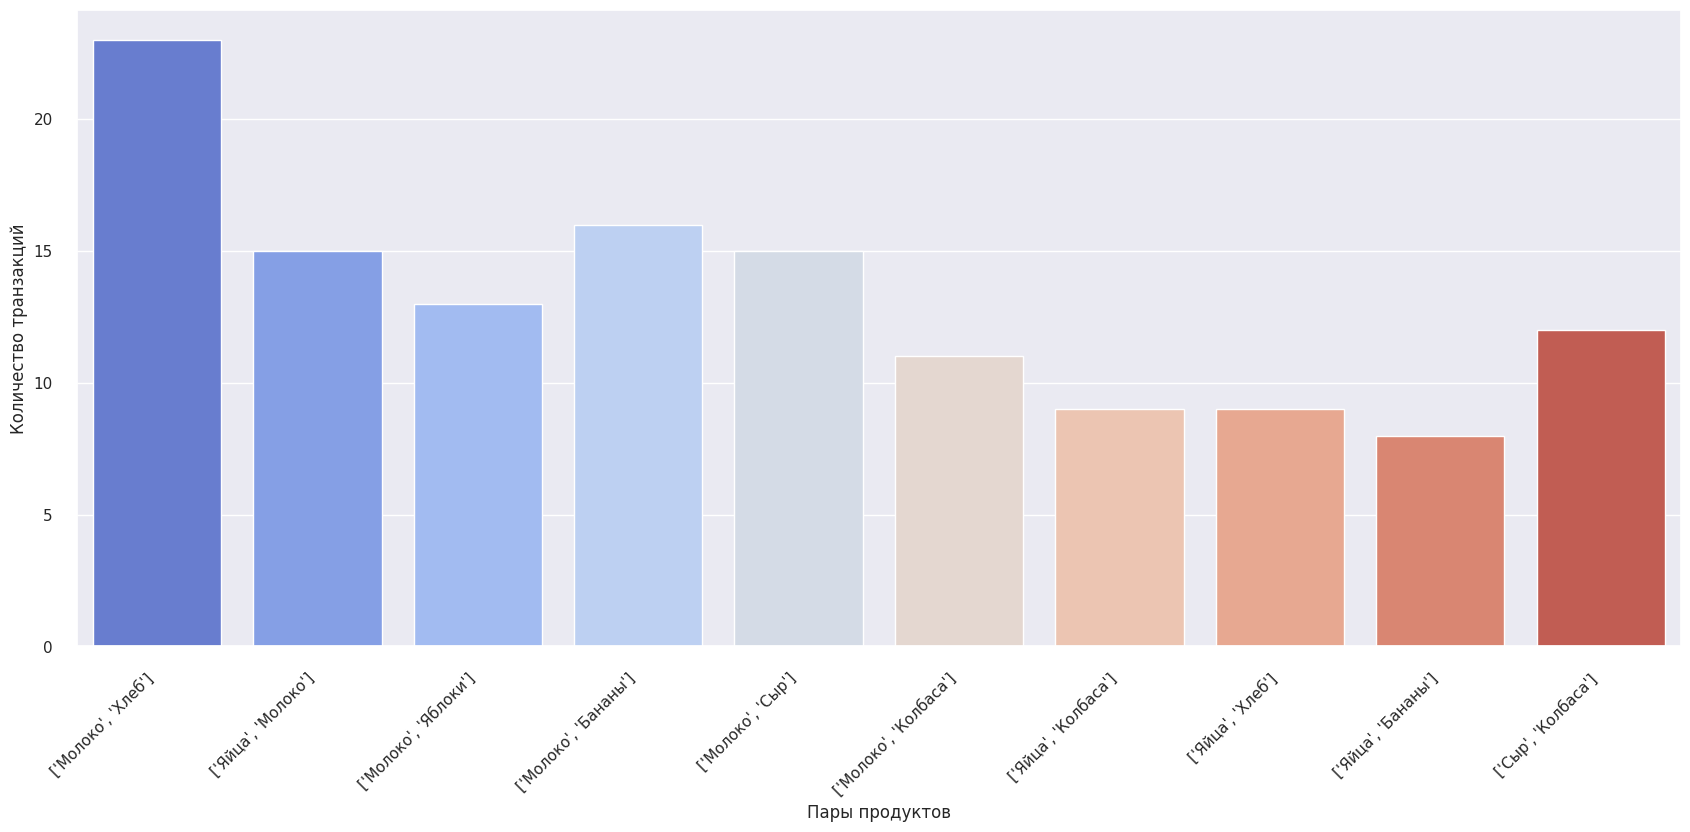

In [38]:
# Используем палитру 'coolwarm' для визуализации
sns.color_palette("coolwarm")
sns.set(rc={'figure.figsize': (20.7, 8.27)})

# Построение столбчатой диаграммы
sns.barplot(data=df_plot, x="Пары продуктов", y="Количество транзакций", palette="coolwarm")

# Показ графика
plt.xticks(rotation=45, ha='right')  # Удобный поворот меток по оси X
plt.show()

In [42]:
# Генерация частых наборов с использованием алгоритма Apriori
f_items = apriori(apriori_basket_set, min_support=0.01, use_colnames=True)

# Генерация правил ассоциации с использованием Apriori
apriori_rules = association_rules(f_items, metric='lift', min_threshold=0.01, num_itemsets=len(apriori_basket_set))

# Сортировка правил по убыванию уверенности
apriori_rules = apriori_rules.sort_values(by='confidence', ascending=False)

# Отображение правил
print(apriori_rules)

                       antecedents                 consequents  \
1568   (Бананы, Помидоры, Морковь)                    (Яблоки)   
736           (Картофель, Конфеты)                   (Морковь)   
1751  (Яйца, Бананы, Молоко, Хлеб)                   (Колбаса)   
1512    (Молоко, Бананы, Помидоры)                     (Масло)   
1500         (Лук, Бананы, Яблоки)                      (Хлеб)   
...                            ...                         ...   
601                       (Молоко)           (Бананы, Морковь)   
607                       (Молоко)           (Бананы, Печенье)   
613                       (Молоко)          (Бананы, Помидоры)   
620                       (Молоко)            (Сливки, Бананы)   
1839                      (Молоко)  (Яйца, Сыр, Колбаса, Хлеб)   

      antecedent support  consequent support  support  confidence       lift  \
1568            0.012270            0.070552  0.01227    1.000000  14.173913   
736             0.012270            0.061350  0

# Визуализация данных для ассоциативных правил
### Сгенерируем тепловую карту ассоциативных правил для минимального порога поддержки в 1%

In [44]:
apriori_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,Количество продуктов (antecedents),Левая часть (antecedents),Правая часть (consequents)
1568,"(Бананы, Помидоры, Морковь)",(Яблоки),0.012270,0.070552,0.01227,1.000000,14.173913,1.0,0.011404,inf,0.940994,0.173913,1.000000,0.586957,3,"Бананы,Помидоры,Морковь",Яблоки
736,"(Картофель, Конфеты)",(Морковь),0.012270,0.061350,0.01227,1.000000,16.300000,1.0,0.011517,inf,0.950311,0.200000,1.000000,0.600000,2,"Картофель,Конфеты",Морковь
1751,"(Яйца, Бананы, Молоко, Хлеб)",(Колбаса),0.012270,0.079755,0.01227,1.000000,12.538462,1.0,0.011291,inf,0.931677,0.153846,1.000000,0.576923,4,"Яйца,Бананы,Молоко,Хлеб",Колбаса
1512,"(Молоко, Бананы, Помидоры)",(Масло),0.012270,0.073620,0.01227,1.000000,13.583333,1.0,0.011367,inf,0.937888,0.166667,1.000000,0.583333,3,"Молоко,Бананы,Помидоры",Масло
1500,"(Лук, Бананы, Яблоки)",(Хлеб),0.012270,0.156442,0.01227,1.000000,6.392157,1.0,0.010350,inf,0.854037,0.078431,1.000000,0.539216,3,"Лук,Бананы,Яблоки",Хлеб
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,(Молоко),"(Бананы, Морковь)",0.162577,0.021472,0.01227,0.075472,3.514825,1.0,0.008779,1.058407,0.854396,0.071429,0.055184,0.323450,1,Молоко,"Бананы,Морковь"
607,(Молоко),"(Бананы, Печенье)",0.162577,0.015337,0.01227,0.075472,4.920755,1.0,0.009776,1.065043,0.951465,0.074074,0.061071,0.437736,1,Молоко,"Бананы,Печенье"
613,(Молоко),"(Бананы, Помидоры)",0.162577,0.021472,0.01227,0.075472,3.514825,1.0,0.008779,1.058407,0.854396,0.071429,0.055184,0.323450,1,Молоко,"Бананы,Помидоры"
620,(Молоко),"(Сливки, Бананы)",0.162577,0.018405,0.01227,0.075472,4.100629,1.0,0.009278,1.061725,0.902930,0.072727,0.058137,0.371069,1,Молоко,"Сливки,Бананы"


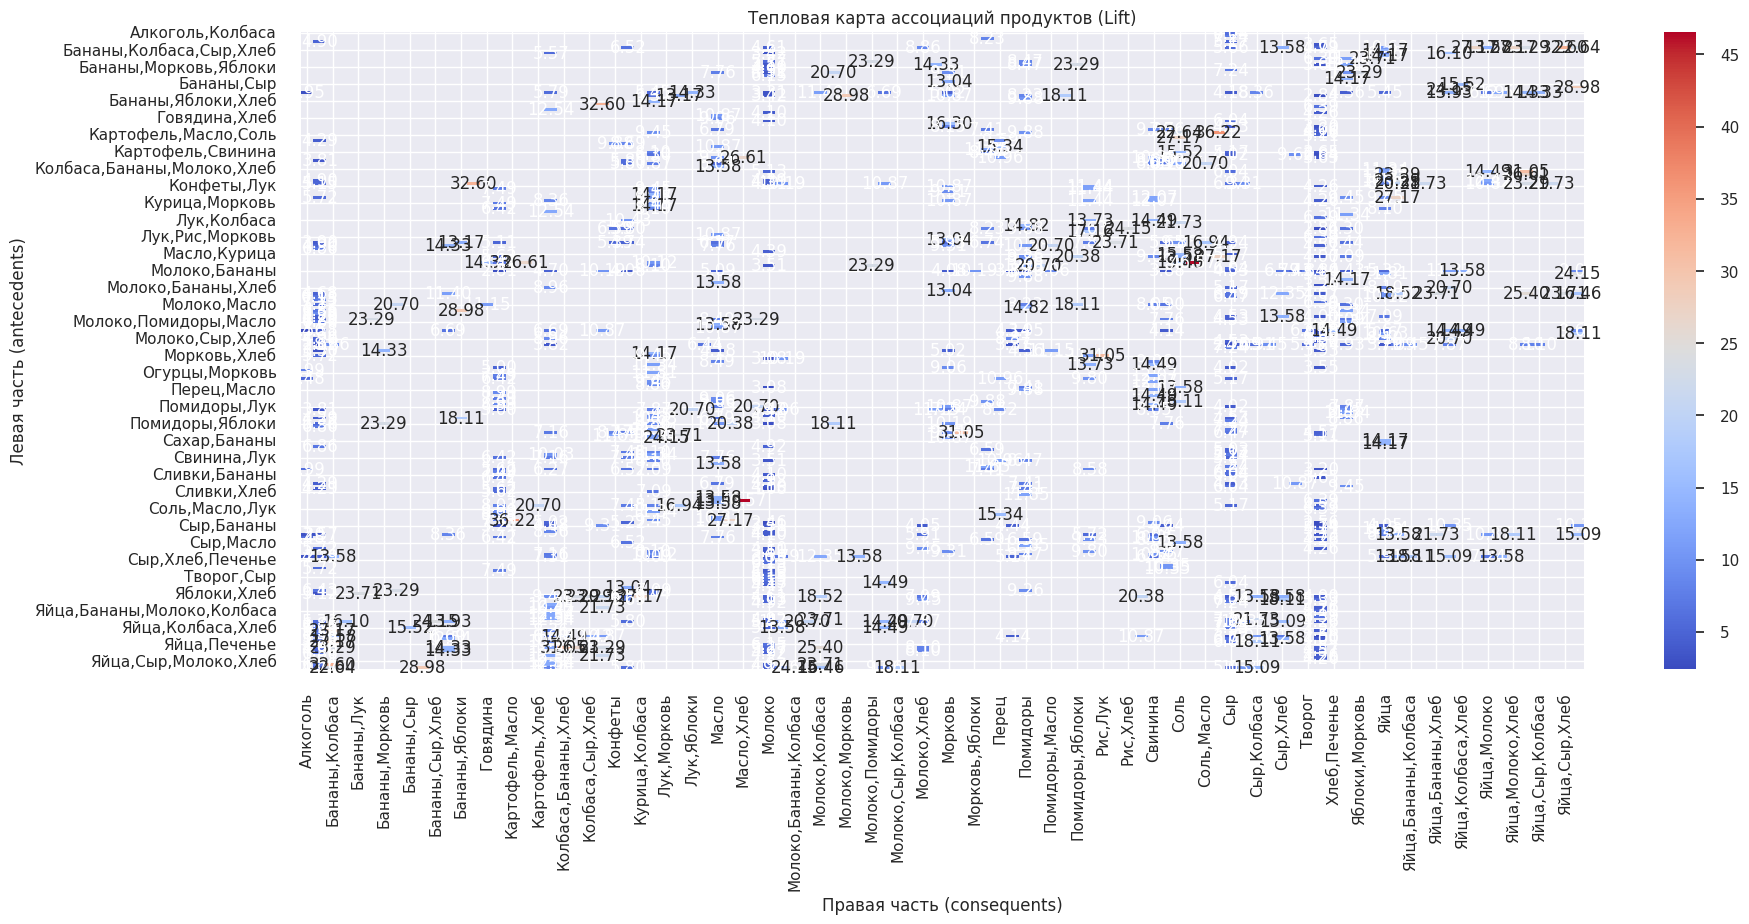

In [45]:
# Проверяем существование столбца 'antecedents' перед выполнением преобразований
if 'antecedents' in apriori_rules.columns:
    # Добавление столбца с количеством элементов в "antecedents"
    apriori_rules['Количество продуктов (antecedents)'] = apriori_rules['antecedents'].apply(lambda x: len(x))

    # Фильтрация правил, где количество элементов в "antecedents" больше 1, и сортировка по lift
    filtered_rules = apriori_rules[apriori_rules['Количество продуктов (antecedents)'] > 1]
    top_rules = filtered_rules.sort_values('lift', ascending=False).head()

    # Преобразование множества в строку для "antecedents" и "consequents"
    apriori_rules['Левая часть (antecedents)'] = apriori_rules['antecedents'].apply(lambda a: ','.join(map(str, a)))
    apriori_rules['Правая часть (consequents)'] = apriori_rules['consequents'].apply(lambda a: ','.join(map(str, a)))

    # Построение сводной таблицы (pivot table) для тепловой карты
    pivot = filtered_rules.pivot(
        index='Левая часть (antecedents)',
        columns='Правая часть (consequents)',
        values='lift'
    )

    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")

    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title("Тепловая карта ассоциаций продуктов (Lift)")
    plt.show()
else:
    print("Ошибка: столбец 'antecedents' отсутствует в данных.")

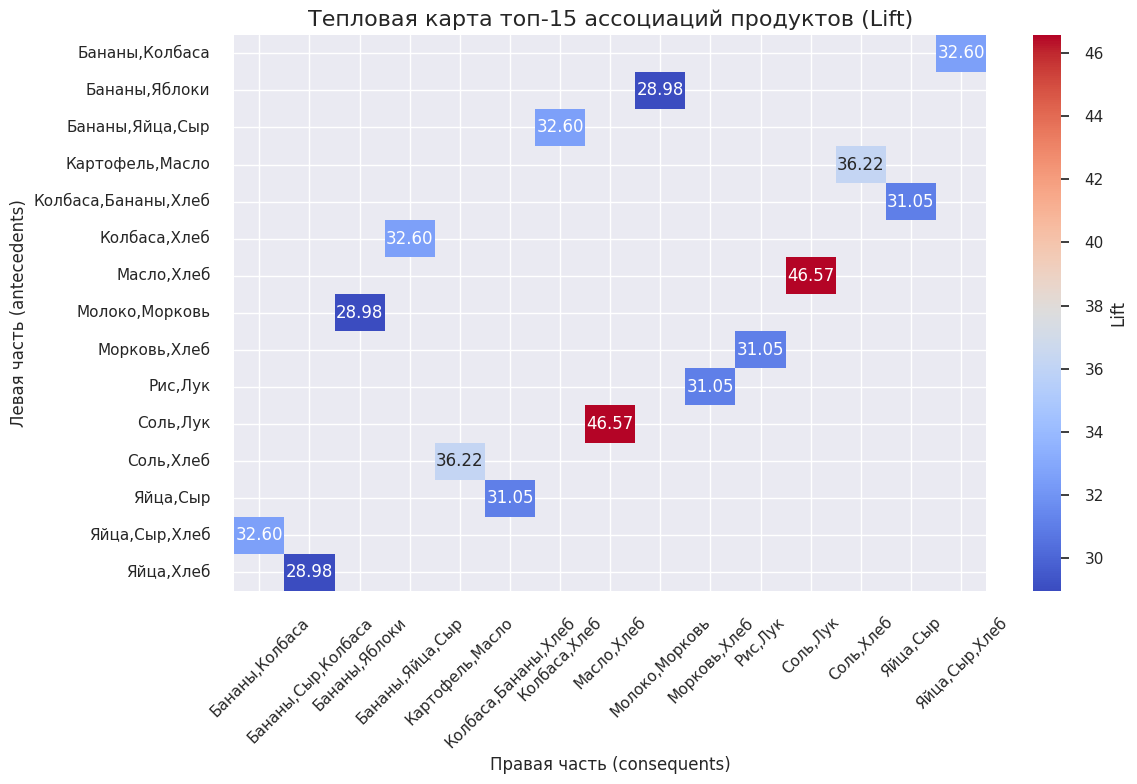

In [46]:
# Фильтруем топ-15 ассоциаций по lift
top_rules = apriori_rules.nlargest(15, 'lift')

# Преобразуем "antecedents" и "consequents" в строки
top_rules['Левая часть (antecedents)'] = top_rules['antecedents'].apply(lambda x: ','.join(list(x)))
top_rules['Правая часть (consequents)'] = top_rules['consequents'].apply(lambda x: ','.join(list(x)))

# Создаем сводную таблицу для топ-15
pivot_filtered = top_rules.pivot(index='Левая часть (antecedents)', columns='Правая часть (consequents)', values='lift')

# Визуализация обновленной тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_filtered, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Lift'})

# Настройки отображения
plt.title("Тепловая карта топ-15 ассоциаций продуктов (Lift)", fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Тепловая карта показывает топ-15 ассоциаций продуктов, где значения Lift демонстрируют силу взаимосвязи между продуктами. Более высокие значения Lift (выделенные яркими цветами) указывают на сильную ассоциацию, например, между продуктами "Колбаса, Бананы, Хлеб". Такие данные могут быть полезны для оптимизации выкладки товаров или создания маркетинговых акций.

In [47]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict
import numpy as np

# Данные правил ассоциации
apriori_vis = apriori_rules.copy()

# Добавляем дополнительные столбцы для подсчетов
apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = len(apriori_basket_set)

# Создаем список транзакций
transactions = [set(row.index[row > 0].tolist()) for _, row in apriori_basket_set.iterrows()]

# Функция для подсчета количества транзакций, содержащих указанный набор
def count_transactions(itemset):
    count = 0
    for transaction in transactions:
        if itemset.issubset(transaction):
            count += 1
    return count

# Преобразуем данные правил в список для обработки
vis = apriori_vis.values.tolist()

# Генерация правил в формате словаря
rules_dict = []
for rule in vis:
    lhs = rule[0]
    rhs = rule[1]
    lhs_count = count_transactions(lhs)
    rhs_count = count_transactions(rhs)
    full_count == count_transactions(lhs.union(rhs))
    rule_dict = {
        'lhs': tuple(lhs),
        'rhs': tuple(rhs),
        'count_full': full_count,
        'count_lhs': lhs_count,
        'count_rhs': rhs_count,
        'num_transactions': len(transactions)
    }
    rules_dict.append(rule_dict)

# Генерация правил в формате PyARMViz
rules = [generate_rule_from_dict(rule_dict) for rule_dict in rules_dict]

# Визуализация правил с помощью PyARMViz
PyARMViz.generate_parallel_category_plot(rules)

На графике представлена параллельная координатная визуализация ассоциативных правил между товарами. Каждый столбец отображает продукты, которые могут быть включены в левую (Antecedent) или правую (Consequent) часть правил. Толщина линий между продуктами указывает на силу связи (Lift).

Основные наблюдения:
- Продукты, такие как "Молоко", "Хлеб" и "Яйца", часто выступают как основные связующие элементы.
- Связи между продуктами в правилах имеют высокую плотность, что говорит о частых совместных покупках.
- Некоторые товары, такие как "Печенье" и "Колбаса", демонстрируют значительные ассоциации с множеством других продуктов.

Это указывает на значимость анализа совместных покупок для оптимизации продаж и маркетинга.

In [52]:
from mlxtend.frequent_patterns import apriori, association_rules
from PyARMViz.Rule import generate_rule_from_dict

# Генерация частых наборов с использованием алгоритма Apriori
f_items = apriori(apriori_basket_set, min_support=0.02, use_colnames=True)  # Увеличили min_support для уменьшения числа правил

# Генерация правил ассоциации
apriori_rules = association_rules(f_items, metric='lift', min_threshold=1.5, num_itemsets=len(apriori_basket_set))  # Увеличили min_threshold
apriori_rules = apriori_rules[apriori_rules['confidence'] > 0.7]  # Фильтруем по высокому уровню confidence
apriori_rules.sort_values('confidence', ascending=False, inplace=True)

# Подготовка данных для визуализации
apriori_vis = apriori_rules.copy()

# Добавление новых столбцов
apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = len(apriori_basket_set)

# Формирование списка транзакций
transactions = [a[1]['Продукт'].tolist() for a in list(apriori_data.groupby('ID Транзакции'))]

# Функция для генерации транзакций
def tran():
    for t in transactions:
        yield t

# Функция для подсчета встречаемости набора в транзакциях
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt += 1
    return cnt

# Преобразование правил в список
vis = apriori_vis.values.tolist()

# Формирование словаря правил
rules_dict = []
for i in vis:
    i[10] = antec(i[0])  # Подсчет для левой части
    i[11] = antec(i[1])  # Подсчет для правой части
    i[9] = antec(i[0].union(i[1]))  # Подсчет для объединения
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

# Генерация списка правил для визуализации
rules = []
for rd in rules_dict:
    rules.append(generate_rule_from_dict(rd))

# Теперь только лучшие правила визуализируются

In [53]:
PyARMViz.generate_parallel_category_plot(rules)

- Продукты, такие как Колбаса, Сыр, Хлеб, и Яйца, имеют высокую взаимосвязь, так как они часто покупаются вместе.
- Молоко и Яблоки также выступают как популярные связанные товары.
- Связи между категориями помогают выявить основные группы продуктов, что может быть использовано для планирования акций или улучшения расположения товаров в магазине.

In [54]:
PyARMViz.generate_rule_graph_plotly(rules)

На представленном графе отображена сеть связей между элементами (продуктами или объектами) на основе выявленных ассоциаций. Узлы (черные точки) представляют продукты, а линии между ними показывают наличие связи или ассоциации, основанной на частоте совместного появления в транзакциях.

Ключевые моменты:
- Узлы с большим числом соединений указывают на продукты, часто ассоциируемые с другими.
- Слабые связи (менее плотные линии) могут указывать на менее значимые ассоциации.
- Общая структура графа демонстрирует, как продукты взаимосвязаны, что может быть полезным для оптимизации выкладки или анализа потребительских предпочтений.

# Заключение

В ходе работы был выполнен аффинитивный анализ покупательских чеков с использованием данных о транзакциях. Основной задачей являлось выявление закономерностей в покупательских предпочтениях и построение моделей ассоциативных правил для анализа связей между товарами. Для этого были проведены этапы предобработки данных, визуализации, анализа частотных наборов и построения ассоциативных правил.

На этапе предобработки данные были очищены и приведены к удобному формату. Количество и стоимость товаров в транзакциях были агрегированы, а для последующего анализа была создана бинарная матрица товаров и транзакций. Эта матрица стала основой для построения моделей ассоциативных правил.

Визуализация данных включала построение различных графиков, таких как распределение общей стоимости транзакций, тренды покупательской активности по времени и тепловые карты совместной покупки товаров. Например, тепловая карта показала соотношение частот совместной покупки товаров и позволила выделить основные популярные пары продуктов. Это дало возможность визуально оценить степень ассоциативности между товарами и обнаружить ключевые взаимосвязи.

С помощью алгоритма Apriori были выявлены частотные наборы товаров, которые часто встречаются в одной транзакции. На их основе были сгенерированы ассоциативные правила, отражающие, какие товары покупаются вместе, с указанием таких метрик, как lift, confidence и support. Эти метрики позволили оценить силу связей между товарами и их значимость в анализе.

Для улучшения наглядности правил была построена тепловая карта ассоциаций, отображающая lift для наиболее значимых пар товаров. Визуализация с использованием PyARMViz дала возможность проследить ассоциации в виде параллельных категорий, что облегчило понимание сложных взаимосвязей в данных.

В ходе анализа были выявлены ключевые пары товаров с наибольшим lift, что говорит о сильной ассоциации между ними. Например, такие товары, как "Хлеб" и "Молоко", "Яйца" и "Сыр", чаще всего встречались в одной транзакции. Это указывает на то, что данные продукты имеют высокую вероятность покупки вместе, что может быть полезно для оптимизации выкладки товаров в магазинах или создания маркетинговых акций.

Дополнительно, анализ распределений стоимости транзакций и их изменения во времени помог выявить особенности поведения покупателей. Большинство транзакций имели небольшую общую стоимость, но также были зафиксированы высокие траты, что свидетельствует о редких крупных покупках.

Итогом работы стало создание инструмента для выявления и визуализации покупательских паттернов. Этот инструмент может быть полезен для повышения продаж через рекомендации или планирование выкладки товаров в торговых точках. Проделанный анализ подтвердил эффективность использования методов анализа частотных наборов и ассоциативных правил для обработки данных о транзакциях.